In [1]:


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split
from numpy.random import randint

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten, RandomRotation
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from keras.models import load_model
from tqdm import tqdm
from random import randint, random, shuffle
import os


2024-03-10 13:51:30.952005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 13:51:30.952118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 13:51:31.081425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
'''seting some config meta data'''
#use this data set on kaggle https://www.kaggle.com/datasets/rain0905/div2k-valid or change the root file to your system

SCALE_FACTOR = 2 #this must be divisable by 2
INPUT_SHAPE = (64,64,3)
OUTPUT_SHAPE = (128,128,3)
BATCH_SIZE = 16
PRETRAIN_PATH = None #defult value must be None if no model is selected
LEARNING_RATE = 1e-6

#[lr_img_folder, Hr_img_folder] remember to fix the root file path to the folder with correct scale
x_train_root = '/kaggle/input/div2k-valid/DIV2K/DIV2K_train_LR_bicubic/X2'
y_train_root = '/kaggle/input/div2k-valid/DIV2K/DIV2K_train_HR'
x_valid_root = '/kaggle/input/div2k-valid/DIV2K/DIV2K_valid_LR_bicubic/X2'
y_valid_root = '/kaggle/input/div2k-valid/DIV2K/DIV2K_valid_HR'

# Create a data generator for image argumentation

In [3]:


def Normalize_img(img):
    return np.divide(img, 255.)

def img_horrizontal_flip(img):
    return tf.image.flip_left_right(img)

def get_patch(x_img, y_img, patch_size, scale_factor):
      # Calculate the maximum possible coordinates for the image height and width for getting patch
      max_x_w = x_img.shape[0] - patch_size[0] + 1
      max_x_h = x_img.shape[1] - patch_size[1] + 1

      max_y_w = y_img.shape[0] - patch_size[0]*scale_factor + 1
      max_y_h = y_img.shape[1] - patch_size[1]*scale_factor + 1

      # Generate random coordinates for the top-left corner
      random_float = random()
      x_img_coord = (int(max_x_w*random_float), int(max_x_h*random_float))
      y_img_coord = (int(max_y_w*random_float), int(max_y_h*random_float))
      #get patches
      x = x_img[x_img_coord[0]:x_img_coord[0]+patch_size[0],
                x_img_coord[1]:x_img_coord[1]+patch_size[1]]

      y = y_img[y_img_coord[0]:y_img_coord[0]+patch_size[0]*scale_factor,
                y_img_coord[1]:y_img_coord[1]+patch_size[1]*scale_factor]

      return (x, y)

def data_generator(data_paths, batch_size=16, patch_size=(32,32), horrizontal_flip=False, rotation=False, scale_factor=2, do_shuffle=True):
  """
  data: a list of tupple containing image path pair of low and high resolution pair EX:(lr_image, hr_image).

  patch_num: number of patches to take from an image.

  patch_size: the size/shape of a patch.

  horrizontal_flip: use filp function or not.
  
  rotation: apply rotaion on image or not.

  scale_factor: the scale_factor low and high resolution pair for all pairs in data_paths.
  """
  x_rotation = RandomRotation(0.2, seed=42)
  y_rotation = RandomRotation(0.2, seed=42)
  hr_sample_shape = (patch_size[0]*scale_factor, patch_size[1]*scale_factor)
  while True:
    patches = []
    for img_pair in data_paths:
      x = img_pair[0]
      y = img_pair[1]
      #load image
      x_img = np.array(tf.keras.utils.load_img(x))
      y_img = np.array(tf.keras.utils.load_img(y))
      #Skip image that is too small for sample
      if y_img.shape[0]< hr_sample_shape[0] or y_img.shape[1]<hr_sample_shape[1]:
        continue
      #flip imgage
      if horrizontal_flip:
        if random()>0.5:
          x_img = img_horrizontal_flip(x_img)
          y_img = img_horrizontal_flip(y_img)
      #rotating image
      if rotation:
        if random()>0.5:
          x_img = x_rotation(x_img)
          y_img = y_rotation(y_img)
      #normalized image
      x_img = Normalize_img(x_img)
      y_img = Normalize_img(y_img)
      #get patches from an image
      for i in range (batch_size):
          x, y = get_patch(x_img, y_img, patch_size, scale_factor)
          patches.append([x, y])
      yield patches
      patches = []
    if do_shuffle:
      shuffle(data_paths)
    else:
      continue
        

def get_batch(generator, batch_num):
    x_batch=[]
    y_batch=[]
    for i in range(batch_num):
        x_mini_batch = []
        y_mini_batch = []
        for pair in next(generator):
            x_mini_batch.append(pair[0])
            y_mini_batch.append(pair[1])
        x_batch.append(x_mini_batch)
        y_batch.append(y_mini_batch)
            
    return (np.asarray(x_batch), np.asarray(y_batch))
  

In [4]:

def get_img_pair(x_root, y_root, scale_factor=2):
    '''give a list of tuple containing pair of low and high resolution image '''
    data_paths=[]
    for _, _, files in os.walk(y_root):
        for name in files:
            #set for different scale factor the factor should be the lower case of y_root img foldler name
            x_name= name.replace('.png', 'x'+str(scale_factor)+'.png')
            pair = (
                os.path.join(x_root, x_name), #this is the x_img path
                os.path.join(y_root, name)    #this is the y_img path
            )
            data_paths.append(pair)
    return data_paths

train_data_paths = get_img_pair(x_train_root, y_train_root, scale_factor=SCALE_FACTOR)
valid_data_paths = get_img_pair(x_valid_root, y_valid_root, scale_factor=SCALE_FACTOR)



train_data_generator = data_generator(train_data_paths, batch_size=BATCH_SIZE, patch_size=(INPUT_SHAPE[0],INPUT_SHAPE[1]), horrizontal_flip= True, rotation=True, scale_factor=SCALE_FACTOR)
valid_generator = data_generator(valid_data_paths, batch_size=BATCH_SIZE, patch_size=(INPUT_SHAPE[0],INPUT_SHAPE[1]), horrizontal_flip= False, scale_factor=SCALE_FACTOR)

In [ ]:
rows = 4
cols = 2
titles = ['low resolution', 'high resolution']

batch = next(train_data_generator)
batch_img=[]

for pair in batch:
  x_img = pair[0]*255
  y_img = pair[1]*255
  batch_img.append(x_img.astype(np.uint8))
  batch_img.append(y_img.astype(np.uint8))


# Create the figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))  # Adjust figsize for desired image size

# Loop through the images and plot them
for i in range(rows):
    for j in range(cols):
        if i * cols + j < len(batch_img):  # Check if index is within image list bounds
            axes[i, j].imshow(batch_img[i * cols + j])
            axes[i, j].set_xticks([])  # Remove ticks for cleaner presentation
            axes[i, j].set_yticks([])

        if i == 0:  # Set title only for the first column of each row
            axes[i, j].set_title(titles[j], fontsize=12)

# Adjust layout (optional)
fig.subplots_adjust(top=0.85)  # Provide more space for column titles
plt.tight_layout()
plt.show()

# Build model

## create function to build

In [ ]:
from os import name

#Architecture
def _get_spatial_ndim(x):
    return keras.backend.ndim(x) - 2


def _get_num_channels(x):
    return keras.backend.int_shape(x)[-1]


def _conv(x, num_filters, kernel_size, padding='same', **kwargs):
    n = _get_spatial_ndim(x)
    if n not in (2, 3):
        raise NotImplementedError(f'{n}D convolution is not supported')

    return (keras.layers.Conv2D if n == 2 else
            keras.layers.Conv3D)(
        num_filters, kernel_size, padding=padding, **kwargs)(x)


def _global_average_pooling(x):
    n = _get_spatial_ndim(x)
    if n == 2:
        return keras.layers.GlobalAveragePooling2D()(x)
    elif n == 3:
        return keras.layers.GlobalAveragePooling3D()(x)
    else:
        raise NotImplementedError(
            f'{n}D global average pooling is not supported')


def _channel_attention_block(x, reduction):
    num_channels = _get_num_channels(x)

    y = _global_average_pooling(x)
    y = keras.layers.Reshape((*(1,) * _get_spatial_ndim(x), num_channels))(y)
    y = _conv(y, num_channels // reduction, 1, activation='relu')
    y = _conv(y, num_channels, 1, activation='sigmoid')

    return keras.layers.Multiply()([x, y])


def _residual_channel_attention_blocks(x,
                                       repeat=1,
                                       channel_reduction=8,
                                       residual_scaling=1.0):
    num_channels = _get_num_channels(x)

    for _ in range(repeat):
        skip = x

        x = _conv(x, num_channels, 3, activation='relu')
        x = _conv(x, num_channels, 3)

        x = _channel_attention_block(x, channel_reduction)

        if residual_scaling != 1.0:
            x = keras.layers.Lambda(lambda x: residual_scaling * x)(x)

        x = keras.layers.Add()([x, skip])

    return x


In [ ]:
"""all convolution layer have padding="same" to keep the orginal image height and width"""

# def res_block(ip):
    
#     res_model = Conv2D(64, (3,3), padding = "same")(ip)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)
#     res_model = PReLU(shared_axes = [1,2])(res_model)
    
#     res_model = Conv2D(64, (3,3), padding = "same")(res_model)
#     res_model = BatchNormalization(momentum = 0.5)(res_model)
    
#     return add([ip,res_model])

def x2_upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model) #up scale the image 
    up_model = PReLU(shared_axes=[1,2])(up_model) 
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block, scale, pretrain_path=None):
    
    #return the pretrain model if a file path is given
    if pretrain_path!=None:
        return load_model(pretrain_path, compile=False)
    
    #make new model if no path is given
    input_shape = gen_ip.shape[1:]
    num_channels = input_shape[-1]
    
    inputs = keras.layers.Input(shape=input_shape)
    x = _conv(inputs, 64, 3)
    
    long_skip = x
    
    for _ in range(num_res_block):
        short_skip = x
        
        x = _residual_channel_attention_blocks(
            x,
            repeat=3,
            channel_reduction=8,
            residual_scaling=1.0)
        
        x = _conv(x, 64, 3)
        x = keras.layers.Add()([x, short_skip])
    
    x = _conv(x, 64, 3)
    x = keras.layers.Add()([x, long_skip])
    
    for _ in range(scale // 2):
        x = x2_upscale_block(x)
    
    outputs = _conv(x, num_channels, 9)
    
    return keras.Model(inputs, outputs)

def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [ ]:
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    #pass the generatied image through vgg for feature extraction
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

## Assemble the model

In [11]:
lr_ip = Input(shape=INPUT_SHAPE)
hr_ip = Input(shape=OUTPUT_SHAPE)

In [ ]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])
# discriminator.summary()

In [ ]:
vgg = build_vgg((128,128,3))
vgg.trainable = False
# vgg.summary()

In [ ]:
generator = create_gen(lr_ip, num_res_block = 5, scale=SCALE_FACTOR, pretrain_path=PRETRAIN_PATH)
# generator.summary()

In [ ]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [ ]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE))
# gan_model.summary()

# Train model

In [ ]:
!mkdir -p saved_model

In [ ]:
max_epochs = 20
batch_num = 512
history = {
    'epoch':[],
    'g_loss':[],
    'd_loss':[],
    'd_acc':[],
}

latest_model = ""

#Enumerate training over epochs
for e in tqdm(range(max_epochs)):
    
    fake_label = np.zeros((BATCH_SIZE, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((BATCH_SIZE,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    f_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(batch_num)):
        x_batch, y_batch = get_batch(train_data_generator, 1)
        lr_imgs = x_batch[0] #Fetch a batch of LR images for training
        hr_imgs = y_batch[0] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images generation
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    history["epoch"].append(e+1) 
    history["g_loss"].append(g_loss)
    history["d_loss"].append(d_loss[0])
    history["d_acc"].append(d_loss[1])
    
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss[0])
        
    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/kaggle/working/saved_model/gen_e_"+ str(e+1) +".h5")
        latest_model = "/kaggle/working/saved_model/gen_e_"+ str(e+1) +".h5"
        


In [ ]:
history_df = pd.DataFrame.from_dict(history)
history_df.to_csv('/kaggle/working/history.csv')
history_df.head()

# Evaluation of model

## Validation Data

In [6]:
# generator = load_model(latest_model, compile=False)
generator = load_model('/kaggle/input/model1/tensorflow2/srgan_version_11/4/gen_e_20_main.h5', compile=False)
#this is for easy copy for the config above 
# SCALE_FACTOR = 2 
# INPUT_SHAPE = (64,64,3)
# OUTPUT_SHAPE = (128,128,3)
# BATCH_SIZE = 16

In [7]:
def PSNR(y_true, y_pred):
  y_true = np.array(y_true, dtype=float).flatten()
  y_pred = np.array(y_pred, dtype=float).flatten()
  mse = np.array(tf.keras.metrics.mean_squared_error(y_true, y_pred))
  return 20*np.log10(1)-10*np.log10(mse)

def SSIM(y_true, y_pred):
  y_true = y_true.astype(np.double)
  y_pred = y_pred.astype(np.double)
  return tf.image.ssim(y_true, y_pred, max_val=1)

In [8]:
x_val, y_val = get_batch(valid_generator, 10)
x_val, y_val = x_val.reshape(-1, *INPUT_SHAPE), y_val.reshape(-1, *OUTPUT_SHAPE)

In [9]:
def evaluate(y_true:np.array, y_pred:np.array):
  PSNR_score = np.mean(PSNR(y_true, y_pred))
  SSIM_score = np.mean(SSIM(y_true, y_pred))
  print(f'PNSR score: {PSNR_score}')
  print(f'SSIM score: {SSIM_score}')

In [10]:

y_pred = np.array(generator.predict(x_val, batch_size=len(x_val)))
print(evaluate(y_val, y_pred))

1/1 [==============================] - 14s 14s/step
PNSR score: 21.943197546282022
SSIM score: 0.6429265141487122
None


In [11]:
def Compare_predicted_image(lr_img, hr_img, model):
    

    src_image, tar_image = lr_img, hr_img

    # generate image from source
    gen_image = model.predict(src_image)
    img_index = int(random()*(len(gen_image)-1))

    plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.title('LR Image')
    plt.imshow(src_image[img_index,:,:,:])
    plt.subplot(232)
    plt.title('Superresolution')
    plt.imshow(gen_image[img_index,:,:,:])
    plt.subplot(233)
    plt.title('Orig. HR image')
    plt.imshow(tar_image[img_index,:,:,:])

    plt.show()

    evaluate(tar_image[img_index,:,:,:], gen_image[img_index,:,:,:])

5/5 [==============================] - 4s 54ms/step


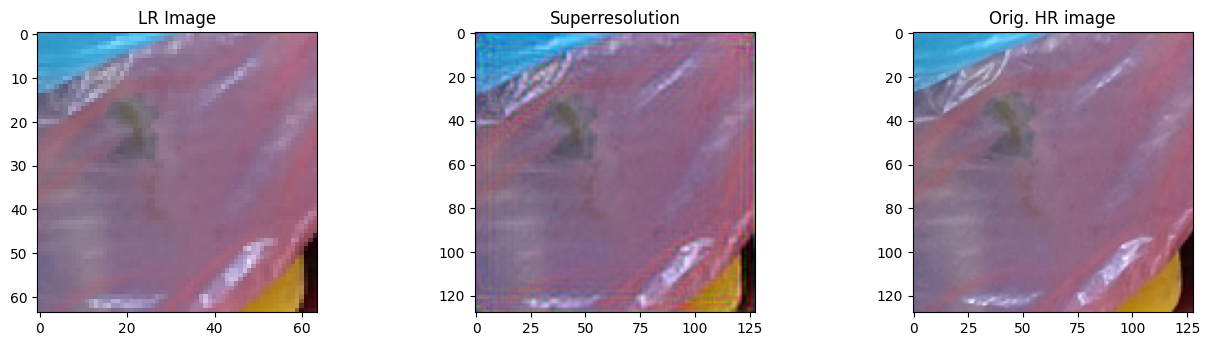

PNSR score: 26.033855436720415
SSIM score: 0.7295418381690979


In [12]:
Compare_predicted_image(x_val, y_val, generator)

## Set5 Data

In [13]:
#SET 5 test dataset
set5_data_paths=[
    (f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_001_SRF_{SCALE_FACTOR}_LR.png', f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_001_SRF_{SCALE_FACTOR}_HR.png'),
    (f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_002_SRF_{SCALE_FACTOR}_LR.png', f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_002_SRF_{SCALE_FACTOR}_HR.png'),
    (f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_003_SRF_{SCALE_FACTOR}_LR.png', f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_003_SRF_{SCALE_FACTOR}_HR.png'),
    (f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_004_SRF_{SCALE_FACTOR}_LR.png', f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_004_SRF_{SCALE_FACTOR}_HR.png'),
    (f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_005_SRF_{SCALE_FACTOR}_LR.png', f'/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_{SCALE_FACTOR}/img_005_SRF_{SCALE_FACTOR}_HR.png')
]

# root = '/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_2'
print(set5_data_paths[1])
set5_generator_2x = data_generator(set5_data_paths,  batch_size=BATCH_SIZE, patch_size=(INPUT_SHAPE[0],INPUT_SHAPE[1]), horrizontal_flip= False, scale_factor=SCALE_FACTOR)

('/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_2/img_002_SRF_2_LR.png', '/kaggle/input/bench-mark-image-datasets/Set5/Set5/image_SRF_2/img_002_SRF_2_HR.png')


In [14]:
set5_x, set5_y = get_batch(set5_generator_2x, 5)
set5_x, set5_y = set5_x.reshape(-1, *INPUT_SHAPE), set5_y.reshape(-1, *OUTPUT_SHAPE)

In [15]:
set5_batch_pred = generator.predict(set5_x, batch_size=len(set5_x))
evaluate(set5_y, set5_batch_pred)

1/1 [==============================] - 7s 7s/step
PNSR score: 22.279447400598293
SSIM score: 0.6368836164474487


5/5 [==============================] - 0s 68ms/step


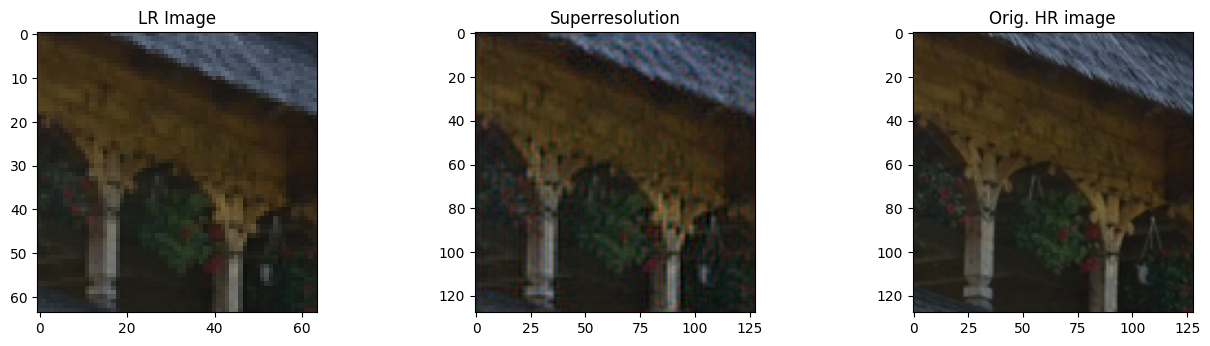

PNSR score: 29.44294595944666
SSIM score: 0.7667210698127747


In [16]:
Compare_predicted_image(x_val, y_val, generator)

## Set14 Data

In [35]:
set14_data_paths = []
set14_root = f'/kaggle/input/bench-mark-image-datasets/Set14/Set14/image_SRF_{SCALE_FACTOR}'
for i in range(14):
    img_id = str(i+1)
    if len(img_id)<2:
        lr_name = f'img_00{i+1}_SRF_{SCALE_FACTOR}_HR.png'
        hr_name = f'img_00{i+1}_SRF_{SCALE_FACTOR}_LR.png'
    if len(img_id)>2:
        lr_name = f'img_0{i+1}_SRF_{SCALE_FACTOR}_HR.png'
        hr_name = f'img_0{i+1}_SRF_{SCALE_FACTOR}_LR.png'
        
    pair = (os.path.join(set14_root, lr_name), os.path.join(set14_root, hr_name))
    set14_data_paths.append(pair)

set14_generator = data_generator(set14_data_paths,  batch_size=BATCH_SIZE, patch_size=(INPUT_SHAPE[0],INPUT_SHAPE[1]), horrizontal_flip= False, scale_factor=SCALE_FACTOR)
set14_x, set14_y = get_batch(set14_generator, 14)
set14_x, set14_y = set14_x.reshape(-1, *INPUT_SHAPE), set14_y.reshape(-1, *OUTPUT_SHAPE)

In [36]:
set14_batch_pred = generator.predict(set14_x, batch_size=len(set14_x))
evaluate(set14_y, set14_batch_pred)

1/1 [==============================] - 0s 29ms/step
PNSR score: 10.736962914126538
SSIM score: 0.16619229316711426


5/5 [==============================] - 0s 68ms/step


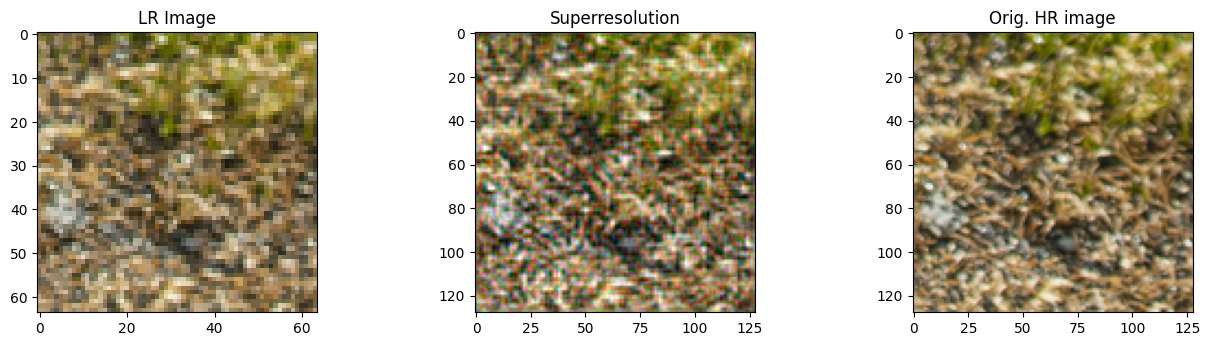

PNSR score: 19.440373095421553
SSIM score: 0.6907446980476379


In [37]:
Compare_predicted_image(x_val, y_val, generator)

## Urban100 Data

In [20]:
urban100_data_paths = []
urban100_root = f'/kaggle/input/bench-mark-image-datasets/Urban100/Urban100/image_SRF_{SCALE_FACTOR}'
for i in range(14):
    img_id = str(i+1)
    if len(img_id)<2:
        lr_name = f'img_00{i+1}_SRF_{SCALE_FACTOR}_HR.png'
        hr_name = f'img_00{i+1}_SRF_{SCALE_FACTOR}_LR.png'
    elif 2<len(img_id)<3:
        lr_name = f'img_0{i+1}_SRF_{SCALE_FACTOR}_HR.png'
        hr_name = f'img_0{i+1}_SRF_{SCALE_FACTOR}_LR.png'
    elif len(img_id)>3:
        lr_name = f'img_{i+1}_SRF_{SCALE_FACTOR}_HR.png'
        hr_name = f'img_{i+1}_SRF_{SCALE_FACTOR}_LR.png'
        
    pair = (os.path.join(urban100_root, lr_name), os.path.join(urban100_root, hr_name))
    urban100_data_paths.append(pair)

urban100_generator = data_generator(urban100_data_paths,  batch_size=int(BATCH_SIZE/4), patch_size=(INPUT_SHAPE[0],INPUT_SHAPE[1]), horrizontal_flip= False, scale_factor=SCALE_FACTOR)
urban100_x, urban100_y = get_batch(urban100_generator, 20)
urban100_x, urban100_y = urban100_x.reshape(-1, *INPUT_SHAPE), urban100_y.reshape(-1, *OUTPUT_SHAPE)

In [21]:
urban100_batch_pred = generator.predict(urban100_x, batch_size=len(urban100_x))
evaluate(urban100_y, urban100_batch_pred)

1/1 [==============================] - 0s 24ms/step
PNSR score: 10.792756145294709
SSIM score: 0.18200676143169403


5/5 [==============================] - 0s 68ms/step


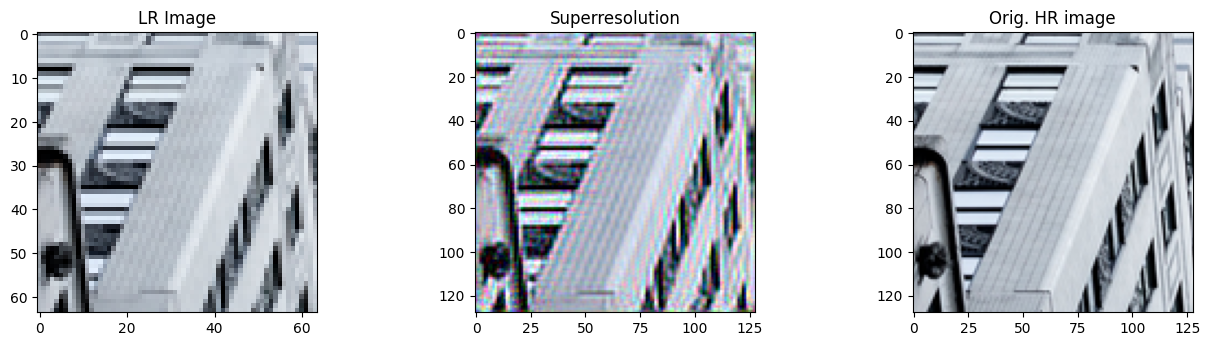

PNSR score: 15.237550148109458
SSIM score: 0.4727793037891388


In [22]:
Compare_predicted_image(x_val, y_val, generator)